##### Import modlues and load data

In [3]:
#@markdown <b>Run me to import underscore module</b><br/>   {display-mode: "form"}
#@markdown <small>Method signatures:</small><br/> 
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _(source_path, target_path)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _set_gh_token(token)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _from_gh(user_name, repo_name, release_name) &nbsp; &nbsp; &nbsp; <b>Returns:</B> dictionary of arrays { 'array_name' : np.ndarray }</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs)</small></small><br/>

!pip install -q githubrelease
import numpy as np
import os, glob, re, time
import github_release

compressed_dirs = set()


def _compress(source_path, target_path, target_dir=None):
    if target_dir:
        !mkdir -p {target_dir}
    if target_path.endswith('.tar.gz'):
        !tar -czf {target_path} -C {source_path} .
    elif target_path.endswith('.tar'):
        !tar -cf {target_path} -C {source_path} .
    elif target_path.endswith('.zip'):
        !(cd {source_path} && zip -q -r {target_path} .)


def _extract(source_path, target_path):
    !mkdir -p {target_path}
    if source_path.endswith('.tar.gz'):
        !tar -xzf {source_path} -C {target_path}
    elif source_path.endswith('.tar'):
        !tar -xf {source_path} -C {target_path}
    elif source_path.endswith('.zip'):
        !unzip -qq {source_path} -d {target_path}


def _(source_path, target_path):
    """
    Use cases:
        Movement:
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Compression (e.g. from dir to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction (e.g. from .zip to dir):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction & compression (e.g. from .zip to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
    """
    COMPRESSION_FORMATS = ('zip', 'tar', 'tar.gz')
    TEMP_DIR = "/tmp_"
    LOG_TEMPLATE = "{}    from    {}    to    {}"

    # Source
    source_dir, _, source_name = source_path.rpartition('/')
    source_isgcs = source_path.startswith("gs://")
    source_islocal = not source_isgcs
    source_isprefix, source_isfile, source_ext = source_name.partition('.')
    source_isdir = not source_isfile
    source_iscompression = source_ext in COMPRESSION_FORMATS

    # Target
    target_dir, _, target_name = target_path.rpartition('/')
    target_isgcs = target_path.startswith("gs://")
    target_islocal = not target_isgcs
    target_prefix, target_isfile, target_ext = target_name.partition('.')
    target_isdir = not target_isfile
    target_iscompression = target_ext in COMPRESSION_FORMATS

    # Flags
    MOVE_ONLY = source_ext == target_ext
    GCS_ONLY = source_isgcs and target_isgcs
    RENAME = source_isprefix != target_prefix
    COMPRESSION = source_isdir and target_iscompression
    EXTRACTION = source_iscompression and target_isdir
    EXTRACTION_COMPRESSION = source_iscompression and target_iscompression and source_ext != target_ext

    # Authenticate if writing to GCS
    if target_isgcs:
        from google.colab import auth
        auth.authenticate_user()

    # Assert that subdirectories exist if target is local
    if target_islocal:
        !mkdir -p {target_dir}

    # Movement commands
    if MOVE_ONLY:
        # GCS -> GCS
        if source_isgcs and target_isgcs:
            print(LOG_TEMPLATE.format("MOVING (1/1)", source_path, target_path))
            !gsutil -m -q mv {source_path} {target_path}
        
        # LOCAL -> LOCAL
        elif source_islocal and target_islocal:
            print(LOG_TEMPLATE.format("MOVING (1/1)", source_path, target_path))
            !mv {source_path} {target_path}
        
        # GCS -> LOCAL
        elif source_isgcs and target_islocal:
            if source_isdir:
                print(LOG_TEMPLATE.format("DOWNLOADING DIR (1/1)", source_path, target_dir))
                !gsutil -m -q cp -r {source_path} {target_dir}
                if RENAME:
                    print(LOG_TEMPLATE.format("\tRENAMING DIR", source_isprefix, target_prefix))
                    !mv {target_dir}/{source_isprefix} {target_dir}/{target_prefix}
            else:
                print(LOG_TEMPLATE.format("DOWNLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        
        # LOCAL -> GCS
        if source_islocal and target_isgcs:
            if source_isdir:
                print(LOG_TEMPLATE.format("UPLOADING DIR (1/1)", source_path, target_path))
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                print(LOG_TEMPLATE.format("UPLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        return


    # Create directory for intermediate storage if required
    if source_isgcs or target_isgcs or EXTRACTION_COMPRESSION:
        !mkdir -p {TEMP_DIR}
    

    # For remaining operations, download GCS source to temp and treat as local
    if source_isgcs:
        if source_isdir:
            print(LOG_TEMPLATE.format("\tDOWNLOADING DIR", source_path, TEMP_DIR))
            !gsutil -m -q cp -r {source_path} {TEMP_DIR}
        else:
            print(LOG_TEMPLATE.format("\tDOWNLOADING FILE", source_path, f"{TEMP_DIR}/{source_name}"))
            !gsutil -m -q cp {source_path} {TEMP_DIR}/{source_name}
        source_path = f"{TEMP_DIR}/{source_name}"
        source_dir = TEMP_DIR

    # Compression
    if COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("COMPRESSING (1/1)", source_path, target_path))
            _compress(source_path, target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("COMPRESSING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _compress(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}

    # Extraction
    elif EXTRACTION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/1)", source_path, target_path))
            _extract(source_path, target_path)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _extract(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING DIR (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp -r {TEMP_DIR}/{target_name} {target_path}

    # Extraction & compression
    elif EXTRACTION_COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/2)", f"{TEMP_DIR}/{target_prefix}", target_path))
            _compress(f"{TEMP_DIR}/{target_prefix}", target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/3)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/3)", f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}"))
            _compress(f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (3/3)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}
    
    # Cleanup intermediate storage
    !rm -rf {TEMP_DIR}


def _set_gh_token(token):
    os.environ["GITHUB_TOKEN"] = token


def _export_array(array, release_name, prefix="", splits=3):
    dir_path = f"/tmp_/{release_name}"
    !mkdir -p {dir_path}
    n_digits = len(str(splits - 1))
    subarrays = np.array_split(array, splits)
    for i, subarray in enumerate(subarrays):
        filename = f"{prefix}__{str(i).zfill(n_digits)}.npy"
        np.save(f"{dir_path}/{filename}", subarray)


def _concat_arrays(paths):
    return np.concatenate([np.load(path, allow_pickle=True) for path in sorted(paths)])


def _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs):
    # Assert that GitHub Auth token is set
    if "GITHUB_TOKEN" not in os.environ:
        print("GitHub authentication token is not set.")
        print("Set token using the '_set_gh_token(token_string)' method.")
        print("Minimal required auth scope is 'repo/public_repo' for public repositories.")
        print("URL: https://github.com/settings/tokens/new")
        return

    # Split arrays
    for prefix, array in arr_kwargs.items():
        splits = int((array.nbytes/1_000_000) // split_size) + 1
        _export_array(array, release_name, prefix=prefix, splits=splits)

    # Upload arrays
    github_release.gh_release_create(
        f"{user_name}/{repo_name}", 
        release_name, 
        publish=True, 
        name=release_name, 
        asset_pattern=f"/tmp_/{release_name}/*"
    )
    !rm -rf /tmp_/*


def _from_gh(user_name, repo_name, release_name):
    # Download release to temporary directory
    print("Downloading dataset in parallell ... ", end='\t')
    t0 = time.perf_counter()
    assets = github_release.get_assets(f"{user_name}/{repo_name}", tag_name=release_name)
    download_urls = [asset['browser_download_url'] for asset in assets]
    urls_str = " ".join(download_urls)
    !echo {urls_str} | xargs -n 1 -P 8 wget -q -P /tmp_/{release_name}_dl/
    t1 = time.perf_counter()
    print(f"done! ({t1 - t0:.3f} seconds)")

    # Load data into numpy arrays
    paths = glob.glob(f"/tmp_/{release_name}_dl/*.npy")
    groups = {}
    for path in paths:
        match = re.match(r".*/(.*)__[0-9]*\.npy", path)
        if match:
            prefix = match.group(1)
            groups[prefix] = groups.get(prefix, []) + [path]
    arrays_dict = {name: _concat_arrays(paths) for name, paths in groups.items()}
    !rm -rf /tmp_/*
    return arrays_dict
    

def _log_to_gh(user, repo, tag, log_dir="/tmp/logs"):
    # Create temporary directory for compressed logs
    !mkdir -p /tmp/compressed_logs
    
    # Compress all directories in log dir
    for dirname in os.listdir(log_dir):
        # Skip files
        if "." in dirname or dirname in compressed_dirs:
            continue

        # Compress
        _(f"{log_dir}/{dirname}", f"/tmp/compressed_logs/{dirname}.tar.gz")
        compressed_dirs.add(dirname)

    # Upload compressed logs to GitHub
    github_release.gh_asset_upload(f"{user}/{repo}", tag, f"/tmp/compressed_logs/*.tar.gz")

    # Cleanup compressed logs
    !rm -rf /tmp/compressed_logs/*

In [8]:
import pandas as pd
import seaborn as sns
from IPython import display
from matplotlib import pyplot as plt

In [4]:
# Download .parquet files
SOURCE_PATH = "gs://telenor-data-science/datasets/location_dataset_parquet"
TARGET_PATH = "/content/location_dataset_parquet"
_(SOURCE_PATH, TARGET_PATH)

# Load all .parquet files as dataframes
dataframes = {}     # Format: {location: pd.DataFrame}
for path in glob.glob(f"{TARGET_PATH}/**/*.parquet", recursive=True):
    df = pd.read_parquet(path)
    location = path.split(os.sep)[-1].split('.')[0]
    dataframes[location] = df

DOWNLOADING DIR (1/1)    from    gs://telenor-data-science/datasets/location_dataset_parquet    to    /content


In [5]:
# Create dataframe for grouped heatmaps
providers = ["MET", "KV", "PRA", "NEA"]
provider_dfs = {provider: pd.DataFrame(columns=['location']) for provider in providers}
# row format: [location, year, ]

for location, df in dataframes.items():
    # Group columns by provider
    col_groups = {provider: [col for col in df.columns if (col.startswith(provider) or col == 'year')]  for provider in providers}

    # For each provider
    for provider, col_group in col_groups.items():
        year_dfs = {x: pd.DataFrame(y) for x, y in df[col_group].groupby('year', as_index=False)}

        # For each year
        years_missing = {'location': location}      # Format: {year: missing_ratio]
        for year, year_df in year_dfs.items():
            year_df = year_df.drop('year', axis=1)
            missing_ratio = year_df.isnull().astype(int).sum().sum() / year_df.size
            #print(f"Year: {year},   Missing ratio: {missing_ratio}")
            years_missing[year] = [1 - missing_ratio]
        
        # Add this locations' missing ratios to provider 
        years_missing_df = pd.DataFrame(years_missing)
        provider_df = provider_dfs[provider]
        
        # Generate colummns in provider dataframe
        for column_name in set(years_missing_df.columns) - set(provider_df.columns):
            provider_df[column_name] = None

        # Add year/location data to provider
        provider_dfs[provider] = provider_df.append(years_missing_df)

# Rearrange columns
provider_dfs = {provider: df.reindex(sorted(df.columns), axis=1).fillna(0).sort_values('location') for provider, df in provider_dfs.items()}

# Create concatenated dataframe for stacked chart
concat_dfs = []
for provider, df in provider_dfs.items():
    df['provider'] = provider
    concat_dfs.append(df)
concat_df = pd.concat(concat_dfs, ignore_index=True)
concat_df = concat_df.set_index(['location', 'provider'])
concat_df = concat_df.sort_values(['location', 'provider'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


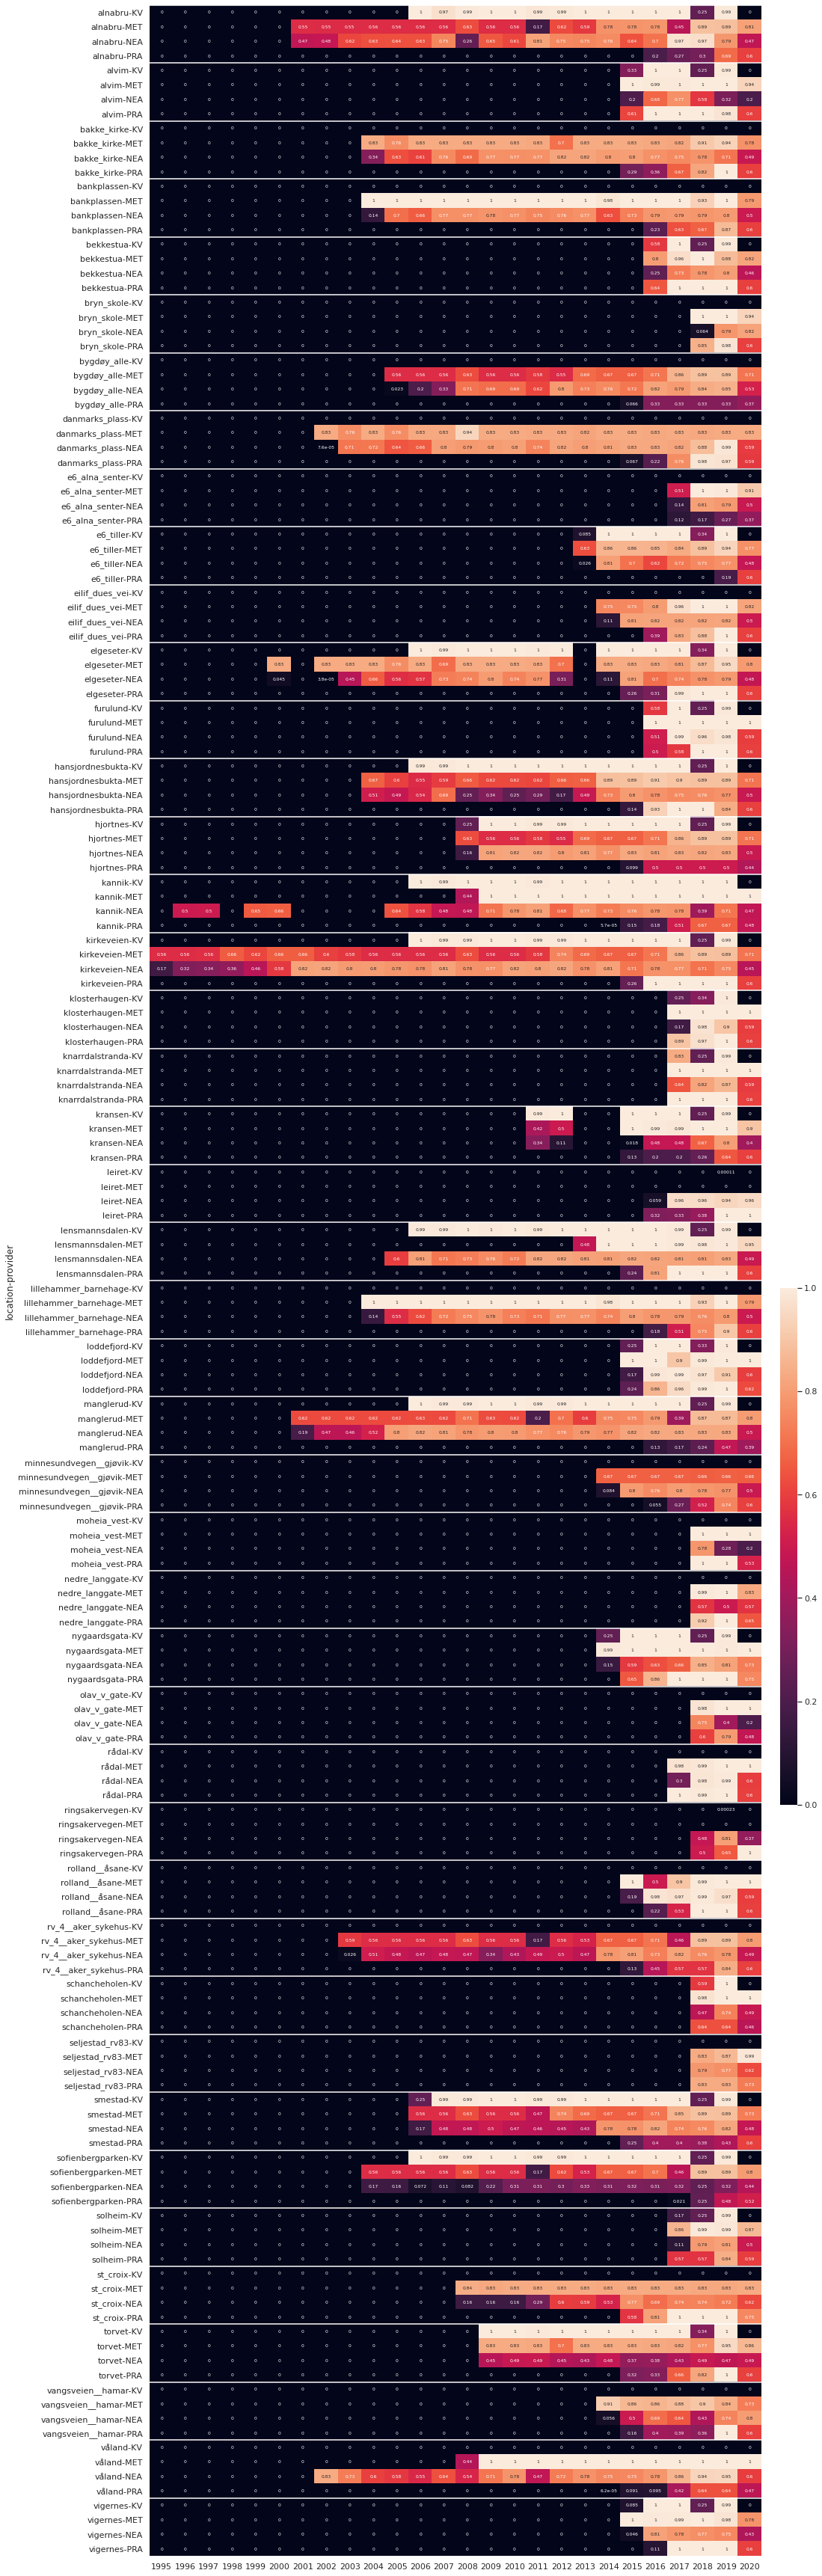

In [9]:
#@title Create stacked heatmap for each provider
"""
sns.set(rc={'figure.figsize':(16,48)})
sns.set_style('whitegrid')
ax = sns.heatmap(concat_df, annot=True, annot_kws={"size": 6})
ax.hlines([4*i for i in range(44)], *ax.get_xlim(), colors='white')
ax.get_figure().savefig('location_heatmap_stacked.png', dpi=288)
"""

sns.set(rc={'figure.figsize':(16,48)})
fig, ax = plt.subplots(1, 1)
cbar_ax = fig.add_axes([.91, .3, .02, .2])
sns.heatmap(concat_df, ax=ax, cbar=True, cbar_ax=cbar_ax, annot=True, annot_kws={"size": 6})
ax.hlines([4*i for i in range(44)], *ax.get_xlim(), colors='white')
fig.tight_layout(rect=[0, 0, .9, 1])
display.clear_output(wait=False)
fig.savefig('location_heatmap_stacked.png', dpi=288)

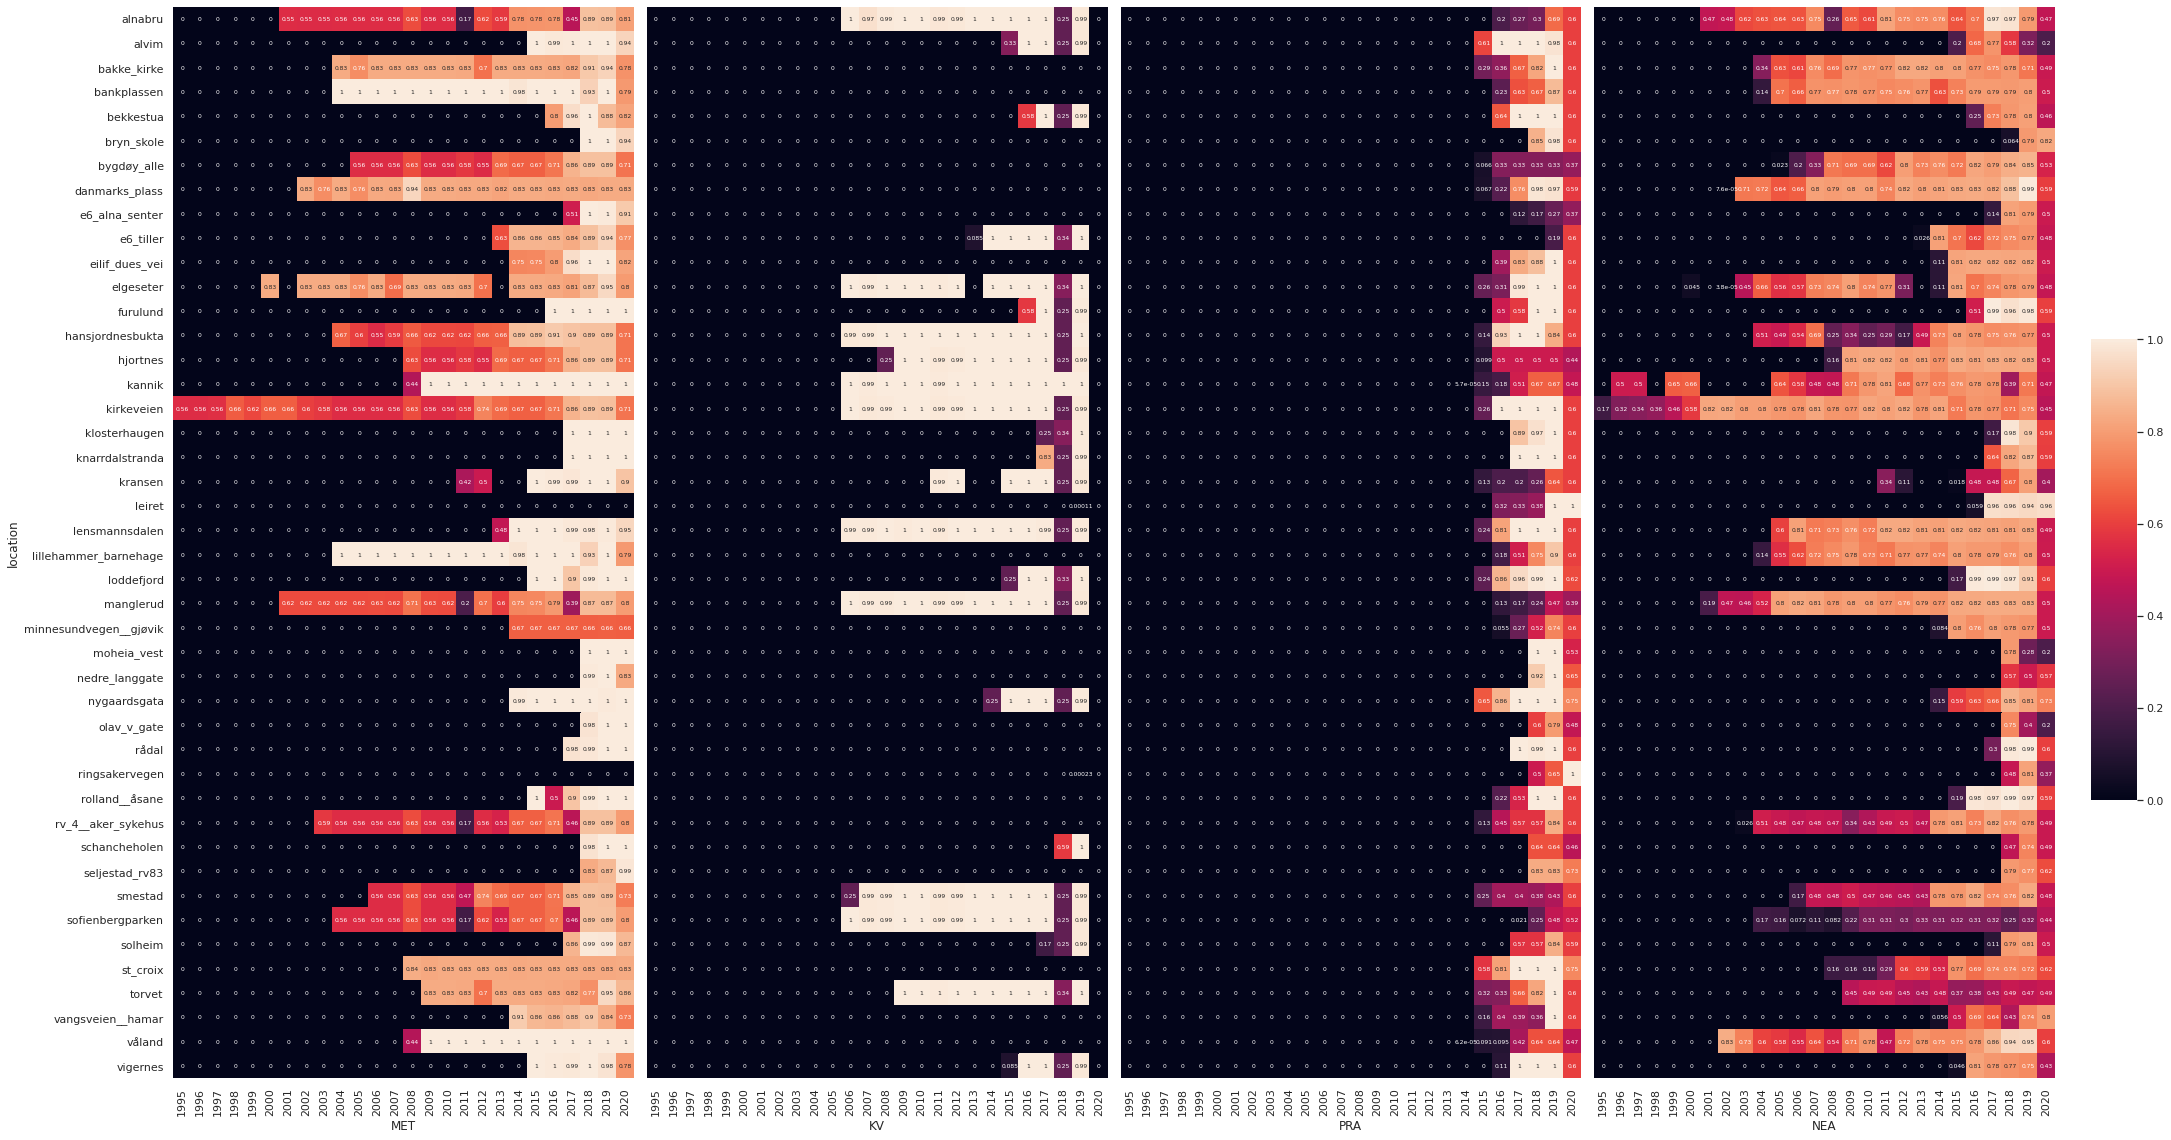

In [11]:
#@title Create separate heatmaps for each provider
sns.set(rc={'figure.figsize':(32,16)})
dataframes_list = list(provider_dfs.items())
fig, axn = plt.subplots(1, 4, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .02, .4])

for i, ax in enumerate(axn.flat):
    provider, df = dataframes_list[i]
    df = df.drop(['provider'], axis=1)
    df = df.set_index('location')
    sns.heatmap(df, ax=ax,cbar=i == 0, cbar_ax=None if i else cbar_ax, annot=True, annot_kws={"size": 6})
    ax.set_xlabel(provider)
    if i != 0:
        ax.set_ylabel(None)

fig.tight_layout(rect=[0, 0, .9, 1])
display.clear_output(wait=False)
fig.savefig('location_heatmap_providers.png', dpi=288)

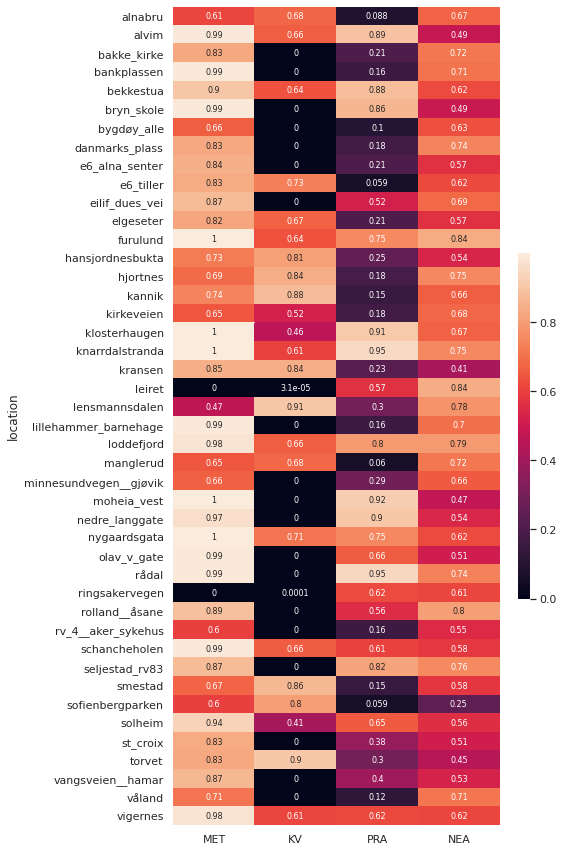

In [ ]:
#@title Create summarized heatmap
providers = ["MET", "KV", "PRA", "NEA"]
heatmap_rows = []
for location, df in dataframes.items():

    # Group columns by provider
    col_groups = {prefix: [col for col in df.columns if col.startswith(prefix)] for prefix in providers}

    # Find percentage of existing data for each provider
    location_data = []
    for prefix, col_group in col_groups.items():
        location_data.append(1 - df[col_group].isnull().sum().sum()/df[col_group].size)
    heatmap_rows.append([location] + location_data)

# Set missing columns to 0% present values and sort by location
heatmap_df = pd.DataFrame(heatmap_rows, columns=['location'] + providers)
heatmap_df = heatmap_df.fillna(0).sort_values('location')

sns.set(rc={'figure.figsize':(8,12)})
fig, ax = plt.subplots(1, 1)
cbar_ax = fig.add_axes([.91, .3, .02, .4])
sns.heatmap(heatmap_df.set_index(['location']), ax=ax, cbar=True, cbar_ax=cbar_ax, annot=True, annot_kws={"size": 8})
fig.tight_layout(rect=[0, 0, .9, 1])
display.clear_output(wait=False)
fig.savefig('location_heatmap_totals.png', dpi=288)